In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.neighbors import DistanceMetric
from math import radians

# julho


 Faltam os dias 3, 4, 5, 6, 12, 19, 26, 27

In [2]:
julho = pd.read_csv('/Users/guilistocco/Documents/TCC 2 - Ônibus/BancoDados/Dados brutos/passengers_julho.csv',
                    index_col= 'Unnamed: 0')

    #  Sao 214k linhas

In [3]:
julho

,timestampI,timestampF,MAC,RSSI,channel,latitudeI,longitudeI,latitudeF,longitudeF,cnt_pckg,id,device_id,duration
0,1625124487,1625124494,f0:b5:d1:5d:08:6e,-42,11,-22.816117,-47.072760,-22.816467,-47.072818,12,0,NaN,7
1,1625124487,1625124493,0c:ef:af:d3:00:1e,-50,11,-22.816117,-47.072760,-22.816412,-47.072808,5,1,NaN,6
2,1625124489,1625124489,0c:f4:d5:15:84:e8,-70,1,-22.816188,-47.072782,-22.816188,-47.072782,2,2,NaN,0
3,1625124494,1625124494,5c:cf:7f:a4:84:9c,-57,11,-22.816467,-47.072818,-22.816467,-47.072818,2,3,NaN,0
4,1625124495,1625124495,e0:10:7f:2e:04:98,-77,6,-22.816513,-47.072823,-22.816513,-47.072823,2,4,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
258638,1627673252,1627673252,a8:16:d0:e3:83:89,-84,5,-22.816417,-47.072804,-22.816417,-47.072804,13,395,NaN,0
258639,1627673253,1627673253,16:aa:a1:63:04:92,-85,12,-22.816416,-47.072803,-22.816416,-47.072803,4,396,NaN,0
258640,1627673257,1627673257,fa:f7:31:db:e6:6f,-90,9,-22.816414,-47.072801,-22.816414,-47.072801,3,397,NaN,0
258641,1627673259,1627673260,06:46:fc:e0:7e:3f,-92,2,-22.816412,-47.072801,-22.816411,-47.072800,8,398,NaN,1



## Preparacao dos dados

In [4]:
julho.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258643 entries, 0 to 258642
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   timestampI  258643 non-null  int64  
 1   timestampF  258643 non-null  int64  
 2   MAC         258643 non-null  object 
 3   RSSI        258643 non-null  int64  
 4   channel     258643 non-null  int64  
 5   latitudeI   258643 non-null  float64
 6   longitudeI  258643 non-null  float64
 7   latitudeF   258643 non-null  float64
 8   longitudeF  258643 non-null  float64
 9   cnt_pckg    258643 non-null  int64  
 10  id          258643 non-null  int64  
 11  device_id   140853 non-null  float64
 12  duration    258643 non-null  int64  
dtypes: float64(5), int64(7), object(1)
memory usage: 27.6+ MB


In [5]:
## Tranforma timestamp em datas

julho['dataInicio'] = pd.to_datetime(julho['timestampI'], unit='s')
julho['dataFim'] = pd.to_datetime(julho['timestampF'], unit='s')

In [6]:
julho = julho[['MAC','latitudeI', 'longitudeI', 'latitudeF', 'longitudeF', 'cnt_pckg', 'duration', 'dataInicio', 'dataFim']]

In [7]:
## Cria a coluna com o dia de cada ping para os agrupamentos

julho['day'] = julho.dataInicio.dt.day

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_68090/538612140.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  julho['day'] = julho.dataInicio.dt.day


In [ ]:
julho[ julho.dataInicio.dt.day  !=  julho.dataFim.dt.day ]

In [8]:
## Cria coluna de ID para cada um dos MACS para facilitar identificacao

MACs_unicos = julho.MAC.unique()

temp = defaultdict(lambda: len(temp))
device_id = [temp[ele] for ele in MACs_unicos]

res = dict(zip(MACs_unicos, device_id))

julho['device_id'] = julho['MAC'].map(res)
julho

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_68090/1907121458.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  julho['device_id'] = julho['MAC'].map(res)


,MAC,latitudeI,longitudeI,latitudeF,longitudeF,cnt_pckg,duration,dataInicio,dataFim,day,device_id
0,f0:b5:d1:5d:08:6e,-22.816117,-47.072760,-22.816467,-47.072818,12,7,2021-07-01 07:28:07,2021-07-01 07:28:14,1,0
1,0c:ef:af:d3:00:1e,-22.816117,-47.072760,-22.816412,-47.072808,5,6,2021-07-01 07:28:07,2021-07-01 07:28:13,1,1
2,0c:f4:d5:15:84:e8,-22.816188,-47.072782,-22.816188,-47.072782,2,0,2021-07-01 07:28:09,2021-07-01 07:28:09,1,2
3,5c:cf:7f:a4:84:9c,-22.816467,-47.072818,-22.816467,-47.072818,2,0,2021-07-01 07:28:14,2021-07-01 07:28:14,1,3
4,e0:10:7f:2e:04:98,-22.816513,-47.072823,-22.816513,-47.072823,2,0,2021-07-01 07:28:15,2021-07-01 07:28:15,1,4
...,...,...,...,...,...,...,...,...,...,...,...
258638,a8:16:d0:e3:83:89,-22.816417,-47.072804,-22.816417,-47.072804,13,0,2021-07-30 19:27:32,2021-07-30 19:27:32,30,11861
258639,16:aa:a1:63:04:92,-22.816416,-47.072803,-22.816416,-47.072803,4,0,2021-07-30 19:27:33,2021-07-30 19:27:33,30,91428
258640,fa:f7:31:db:e6:6f,-22.816414,-47.072801,-22.816414,-47.072801,3,0,2021-07-30 19:27:37,2021-07-30 19:27:37,30,91429
258641,06:46:fc:e0:7e:3f,-22.816412,-47.072801,-22.816411,-47.072800,8,1,2021-07-30 19:27:39,2021-07-30 19:27:40,30,91430


In [9]:
## Adiciona sequence para identificar dentro de um dia de qual a o numero da conexao atual (em uma lista ordenada)

julho.sort_values(by= ['device_id', 'dataInicio'], inplace = True)

julho['sequence'] = julho.groupby(['device_id', 'day']).cumcount()+1

julho.reset_index(drop = True, inplace = True)

julho

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_68090/3862337680.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  julho.sort_values(by= ['device_id', 'dataInicio'], inplace = True)
/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_68090/3862337680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  julho['sequence'] = julho.groupby(['device_id', 'day']).cumcount()+1


,MAC,latitudeI,longitudeI,latitudeF,longitudeF,cnt_pckg,duration,dataInicio,dataFim,day,device_id,sequence
0,f0:b5:d1:5d:08:6e,-22.816117,-47.072760,-22.816467,-47.072818,12,7,2021-07-01 07:28:07,2021-07-01 07:28:14,1,0,1
1,f0:b5:d1:5d:08:6e,-22.816290,-47.072612,-22.816483,-47.072838,2,1676,2021-07-01 07:31:22,2021-07-01 07:59:18,1,0,2
2,f0:b5:d1:5d:08:6e,-22.816298,-47.072655,-22.815973,-47.072783,224,2530,2021-07-01 08:10:05,2021-07-01 08:52:15,1,0,3
3,f0:b5:d1:5d:08:6e,-22.816291,-47.072668,-22.816490,-47.072747,105,2117,2021-07-01 09:03:08,2021-07-01 09:38:25,1,0,4
4,f0:b5:d1:5d:08:6e,-22.816172,-47.072777,-22.816473,-47.072794,7,8,2021-07-01 11:02:31,2021-07-01 11:02:39,1,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
258638,b2:b4:bf:5a:ea:ea,-22.816417,-47.072804,-22.816417,-47.072804,3,0,2021-07-30 19:27:32,2021-07-30 19:27:32,30,91427,1
258639,16:aa:a1:63:04:92,-22.816416,-47.072803,-22.816416,-47.072803,4,0,2021-07-30 19:27:33,2021-07-30 19:27:33,30,91428,1
258640,fa:f7:31:db:e6:6f,-22.816414,-47.072801,-22.816414,-47.072801,3,0,2021-07-30 19:27:37,2021-07-30 19:27:37,30,91429,1
258641,06:46:fc:e0:7e:3f,-22.816412,-47.072801,-22.816411,-47.072800,8,1,2021-07-30 19:27:39,2021-07-30 19:27:40,30,91430,1


In [10]:
## Criando coluna de duracao da conexao entre os pings

julho['duration(s)'] = (julho['dataFim'] - julho['dataInicio']).dt.total_seconds()

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_68090/279658518.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  julho['duration(s)'] = (julho['dataFim'] - julho['dataInicio']).dt.total_seconds()


In [11]:
## funcao de calculo de distancia entre o ponto de inicio e fim da conexao

def haversine_vectorize(lon1, lat1, lon2, lat2):
    # print(lon1, lat1, lon2, lat2)
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    newlon = lon2 - lon1
    newlat = lat2 - lat1

    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    m = 6_367_000 * dist #6367 for distance in KM for miles use 3958
    return m

julho['distance(m)'] = julho.apply(lambda x : haversine_vectorize(x['longitudeI'], x['latitudeI'], x['longitudeF'], x['latitudeF']), axis = 1)

julho

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_68090/1699382427.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  julho['distance(m)'] = julho.apply(lambda x : haversine_vectorize(x['longitudeI'], x['latitudeI'], x['longitudeF'], x['latitudeF']), axis = 1)


,MAC,latitudeI,longitudeI,latitudeF,longitudeF,cnt_pckg,duration,dataInicio,dataFim,day,device_id,sequence,duration(s),distance(m)
0,f0:b5:d1:5d:08:6e,-22.816117,-47.072760,-22.816467,-47.072818,12,7,2021-07-01 07:28:07,2021-07-01 07:28:14,1,0,1,7.0,39.344905
1,f0:b5:d1:5d:08:6e,-22.816290,-47.072612,-22.816483,-47.072838,2,1676,2021-07-01 07:31:22,2021-07-01 07:59:18,1,0,2,1676.0,31.557295
2,f0:b5:d1:5d:08:6e,-22.816298,-47.072655,-22.815973,-47.072783,224,2530,2021-07-01 08:10:05,2021-07-01 08:52:15,1,0,3,2530.0,38.421875
3,f0:b5:d1:5d:08:6e,-22.816291,-47.072668,-22.816490,-47.072747,105,2117,2021-07-01 09:03:08,2021-07-01 09:38:25,1,0,4,2117.0,23.547913
4,f0:b5:d1:5d:08:6e,-22.816172,-47.072777,-22.816473,-47.072794,7,8,2021-07-01 11:02:31,2021-07-01 11:02:39,1,0,5,8.0,33.493954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258638,b2:b4:bf:5a:ea:ea,-22.816417,-47.072804,-22.816417,-47.072804,3,0,2021-07-30 19:27:32,2021-07-30 19:27:32,30,91427,1,0.0,0.000000
258639,16:aa:a1:63:04:92,-22.816416,-47.072803,-22.816416,-47.072803,4,0,2021-07-30 19:27:33,2021-07-30 19:27:33,30,91428,1,0.0,0.000000
258640,fa:f7:31:db:e6:6f,-22.816414,-47.072801,-22.816414,-47.072801,3,0,2021-07-30 19:27:37,2021-07-30 19:27:37,30,91429,1,0.0,0.000000
258641,06:46:fc:e0:7e:3f,-22.816412,-47.072801,-22.816411,-47.072800,8,1,2021-07-30 19:27:39,2021-07-30 19:27:40,30,91430,1,1.0,0.151131


In [12]:
## Coluna de velocidade media para avalicao se os movimentos sao coerentes

julho['velMed(km/h)'] = julho['distance(m)']/julho['duration(s)'] *3.6
julho

,MAC,latitudeI,longitudeI,latitudeF,longitudeF,cnt_pckg,duration,dataInicio,dataFim,day,device_id,sequence,duration(s),distance(m),velMed(km/h)
0,f0:b5:d1:5d:08:6e,-22.816117,-47.072760,-22.816467,-47.072818,12,7,2021-07-01 07:28:07,2021-07-01 07:28:14,1,0,1,7.0,39.344905,20.234523
1,f0:b5:d1:5d:08:6e,-22.816290,-47.072612,-22.816483,-47.072838,2,1676,2021-07-01 07:31:22,2021-07-01 07:59:18,1,0,2,1676.0,31.557295,0.067784
2,f0:b5:d1:5d:08:6e,-22.816298,-47.072655,-22.815973,-47.072783,224,2530,2021-07-01 08:10:05,2021-07-01 08:52:15,1,0,3,2530.0,38.421875,0.054671
3,f0:b5:d1:5d:08:6e,-22.816291,-47.072668,-22.816490,-47.072747,105,2117,2021-07-01 09:03:08,2021-07-01 09:38:25,1,0,4,2117.0,23.547913,0.040044
4,f0:b5:d1:5d:08:6e,-22.816172,-47.072777,-22.816473,-47.072794,7,8,2021-07-01 11:02:31,2021-07-01 11:02:39,1,0,5,8.0,33.493954,15.072279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258638,b2:b4:bf:5a:ea:ea,-22.816417,-47.072804,-22.816417,-47.072804,3,0,2021-07-30 19:27:32,2021-07-30 19:27:32,30,91427,1,0.0,0.000000,NaN
258639,16:aa:a1:63:04:92,-22.816416,-47.072803,-22.816416,-47.072803,4,0,2021-07-30 19:27:33,2021-07-30 19:27:33,30,91428,1,0.0,0.000000,NaN
258640,fa:f7:31:db:e6:6f,-22.816414,-47.072801,-22.816414,-47.072801,3,0,2021-07-30 19:27:37,2021-07-30 19:27:37,30,91429,1,0.0,0.000000,NaN
258641,06:46:fc:e0:7e:3f,-22.816412,-47.072801,-22.816411,-47.072800,8,1,2021-07-30 19:27:39,2021-07-30 19:27:40,30,91430,1,1.0,0.151131,0.544073


## Agrupamentio dos usuarios por dias contando numero de conexoes

Aqui pode haver mais coisas a se fazer

Como eh possivel ver no caso do dia=1 device=0
 - a data de inicio eh no dia 1, e a data fim eh no dia 2
 - isso nao acontece pra todos os devices, mas para os que acontecem pode ser retrabalhado

In [13]:
julho_group = julho.groupby(['day','device_id']).agg({
                                                        'dataInicio': 'min',
                                                        'dataFim':'max',
                                                        'sequence':'count',
                                                        'distance(m)':'sum',
                                                        'duration(s)':'sum'
})
julho_group

dataInicio             dataFim  sequence  distance(m)  \
day device_id                                                                  
1   0         2021-07-01 07:28:07 2021-07-01 19:27:37        16   727.104821   
    1         2021-07-01 07:28:07 2021-07-01 19:27:37        16   683.596564   
    2         2021-07-01 07:28:09 2021-07-01 18:59:29        12   134.529630   
    3         2021-07-01 07:28:14 2021-07-01 19:27:30        16   627.202514   
    4         2021-07-01 07:28:15 2021-07-01 19:02:56        13   323.321487   
...                           ...                 ...       ...          ...   
30  91427     2021-07-30 19:27:32 2021-07-30 19:27:32         1     0.000000   
    91428     2021-07-30 19:27:33 2021-07-30 19:27:33         1     0.000000   
    91429     2021-07-30 19:27:37 2021-07-30 19:27:37         1     0.000000   
    91430     2021-07-30 19:27:39 2021-07-30 19:27:40         1     0.151131   
    91431     2021-07-30 19:27:44 2021-07-30 19:27:44         1     0.000000   

               duration(s)  
day device_id               
1   0              27518.0  
    1              27494.0  
    2               7199.0  
    3              27311.0  
    4               8880.0  
...                    ...  
30  91427              0.0  
    91428              0.0  
    91429              0.0  
    91430              1.0  
    91431              0.0  

[143657 rows x 5 columns]

#### Recuperando a primeira e ultima coordenada

 - Usando o usuario/MAC e o primeiro e ultimo momento em conexao
 - Buscar as coordenadas desses dispositivos nesse instante (inicial e final)
 - Comparar com a coordenada dos pontos de onibus para determinar qual o ponto de embarque do passageiro e ponto de desembarque

In [14]:
julho_coordenadas = julho_group.merge(julho[['day','device_id', 'dataInicio', 'latitudeI', 'longitudeI']],  
                                        right_on= ['day', 'device_id', 'dataInicio'], 
                                        left_on=  ['day','device_id', 'dataInicio']).merge(
                                            julho[['day','device_id', 'dataFim', 'latitudeF', 'longitudeF']],  
                                            right_on= ['day', 'device_id', 'dataFim'], 
                                            left_on=  ['day','device_id', 'dataFim'])
julho_coordenadas

,day,device_id,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF
0,1,0,2021-07-01 07:28:07,2021-07-01 19:27:37,16,727.104821,27518.0,-22.816117,-47.072760,-22.816604,-47.072880
1,1,1,2021-07-01 07:28:07,2021-07-01 19:27:37,16,683.596564,27494.0,-22.816117,-47.072760,-22.816604,-47.072880
2,1,2,2021-07-01 07:28:09,2021-07-01 18:59:29,12,134.529630,7199.0,-22.816188,-47.072782,-22.816320,-47.072619
3,1,3,2021-07-01 07:28:14,2021-07-01 19:27:30,16,627.202514,27311.0,-22.816467,-47.072818,-22.816490,-47.072878
4,1,4,2021-07-01 07:28:15,2021-07-01 19:02:56,13,323.321487,8880.0,-22.816513,-47.072823,-22.816197,-47.072646
...,...,...,...,...,...,...,...,...,...,...,...
144421,30,91427,2021-07-30 19:27:32,2021-07-30 19:27:32,1,0.000000,0.0,-22.816417,-47.072804,-22.816417,-47.072804
144422,30,91428,2021-07-30 19:27:33,2021-07-30 19:27:33,1,0.000000,0.0,-22.816416,-47.072803,-22.816416,-47.072803
144423,30,91429,2021-07-30 19:27:37,2021-07-30 19:27:37,1,0.000000,0.0,-22.816414,-47.072801,-22.816414,-47.072801
144424,30,91430,2021-07-30 19:27:39,2021-07-30 19:27:40,1,0.151131,1.0,-22.816412,-47.072801,-22.816411,-47.072800


## Selecao de passageiros validos

#### Histograma Duration 
    - entre um minuto e uma hora de viagem
    - pelo menos 300m percorridos

Conclusao: Concentracao viagens de curta ducarao (ate 10 minutos)

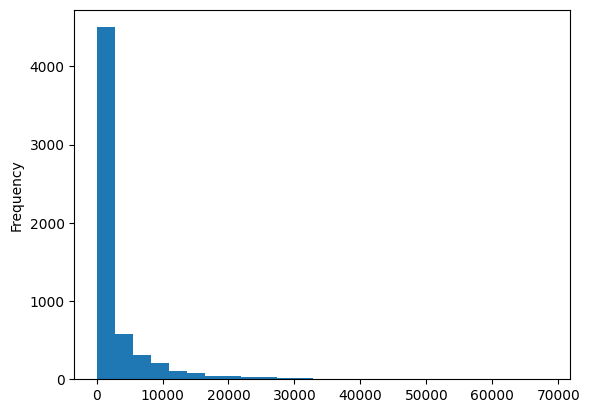

In [15]:

julho_coordenadas.loc[  ((  julho_coordenadas['duration(s)'] > 60   ) ) &
                        ((  julho_coordenadas['distance(m)'] > 300   )  ), 'duration(s)'].plot(kind='hist', bins = 25);

##### Casos para corte dos passageiros validos

- Ha casos em que a duracao conexao de um passageiro eh superior a 47000 segundos (12h)
    - isso ocorre para passageiros que usam a linha diariamente
    - assim a dataInicio ocorre no fim de um dia e a dataFim no inicio de outro
- Com isso deve-se faze rum corte para retirar essas anomalia

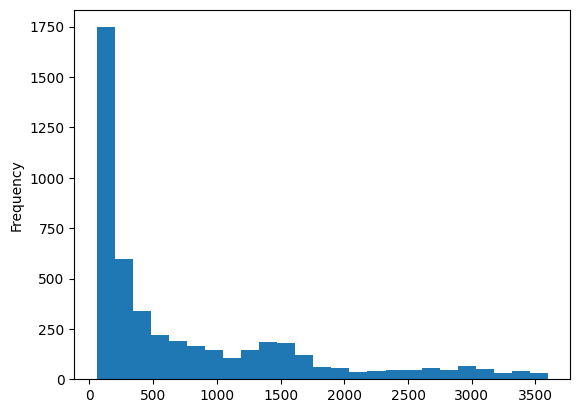

In [16]:
julho_coordenadas.loc[  ((  julho_coordenadas['duration(s)'] > 60   ) & (  julho_coordenadas['duration(s)'] < 3600   ) ) &
                        ((  julho_coordenadas['distance(m)'] > 300   )  ), 'duration(s)'].plot(kind='hist', bins = 25);

#### Histograma Distance 
    - entre um minuto e uma hora de viagem
    - pelo menos 300m percorridos

##### Conclusao: Absoluta concentracao viagens de curta ducarao (ate 10 minutos)

    - 95% percentil de viagens é de 2km
    - Sao 230 viagens com mais de 2km, razoavel retirar sujeira

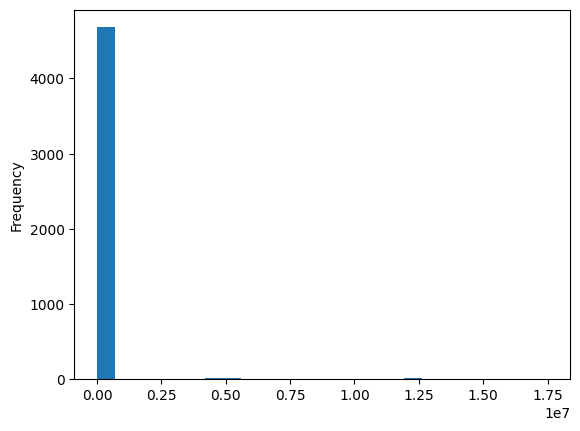

In [17]:

julho_coordenadas.loc[  ((  julho_coordenadas['duration(s)'] > 60   ) & (  julho_coordenadas['duration(s)'] < 3600   ) ) &
                        ((  julho_coordenadas['distance(m)'] > 300   )  ), 'distance(m)'].plot(kind='hist', bins = 25);

In [18]:

julho_coordenadas.loc[  ((  julho_coordenadas['duration(s)'] > 60   ) & (  julho_coordenadas['duration(s)'] < 3600   ) ) &
                        ((  julho_coordenadas['distance(m)'] > 300   )  ), 'distance(m)'].describe(percentiles=[ .25, .5, .75, .80, .85, .90, .95])
# sao 4030

count    4.752000e+03
mean     1.037080e+05
std      9.442346e+05
min      3.000552e+02
25%      4.323389e+02
50%      6.279833e+02
75%      9.704257e+02
80%      1.128292e+03
85%      1.296143e+03
90%      1.546092e+03
95%      2.044514e+03
max      1.750816e+07
Name: distance(m), dtype: float64

In [19]:

julho_coordenadas.loc[  ((  julho_coordenadas['duration(s)'] > 60   ) & (  julho_coordenadas['duration(s)'] < 3600   ) ) &
                        ((  julho_coordenadas['distance(m)'] > 2000   )  ) ]

,day,device_id,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF
127,1,127,2021-07-01 07:38:52,2021-07-01 19:13:59,13,2.592078e+03,2659.0,-22.827171,-47.067544,-22.827035,-47.067519
333,1,333,2021-07-01 07:50:12,2021-07-01 18:06:39,11,2.529727e+03,1087.0,-22.813675,-47.060613,-22.813270,-47.063691
354,1,354,2021-07-01 07:50:59,2021-07-01 18:06:43,11,2.785158e+03,1930.0,-22.814539,-47.057198,-22.813482,-47.063529
2143,1,2139,2021-07-01 12:23:06,2021-07-01 16:15:15,3,2.099418e+03,1449.0,-22.815199,-47.072564,-22.831260,-47.063658
3960,1,3956,2021-07-01 17:50:10,2021-07-01 17:57:05,1,2.076847e+03,415.0,-22.813829,-47.070396,-22.831374,-47.063410
...,...,...,...,...,...,...,...,...,...,...,...
139150,30,4528,2021-07-30 06:58:26,2021-07-30 16:25:23,3,7.215975e+06,1235.0,-22.812746,-47.067817,-22.812711,-47.065759
139296,30,5609,2021-07-30 07:28:24,2021-07-30 14:17:02,8,2.045796e+03,286.0,-22.819297,-47.059983,-22.821679,-47.060823
139409,30,6369,2021-07-30 07:57:11,2021-07-30 17:50:01,4,4.867449e+06,176.0,-22.821808,-47.069533,-22.816294,-47.072639
139527,30,7431,2021-07-30 11:15:44,2021-07-30 17:08:23,2,4.869234e+06,256.0,-22.829558,-47.062650,-22.829584,0.700000


In [20]:

julho_coordenadas.loc[  ((  julho_coordenadas['duration(s)'] > 60   ) & (  julho_coordenadas['duration(s)'] < 3600   ) ) &
                        ((  julho_coordenadas['distance(m)'] > 2000   )  ), 'distance(m)'].describe(percentiles=[ .25, .5, .75, .80, .85, .90, .95])
# sao 4030

count    2.530000e+02
mean     1.935166e+06
std      3.640353e+06
min      2.001748e+03
25%      2.283575e+03
50%      2.956968e+03
75%      2.577419e+06
80%      4.879155e+06
85%      5.072732e+06
90%      7.184347e+06
95%      1.234410e+07
max      1.750816e+07
Name: distance(m), dtype: float64

### Passageiros Validos

Foi adotado a duracao das viagens entre 60s e 1h

e com distancia percorrida entre 300m e 2,125km



In [21]:
validas_julho = julho_coordenadas.loc[  ((  julho_coordenadas['duration(s)'] > 60   ) & (  julho_coordenadas['duration(s)'] < 3600   ) ) &
                        ((  julho_coordenadas['distance(m)'] > 300  ) & (  julho_coordenadas['distance(m)'] < 2125   )  )]
validas_julho

,day,device_id,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF
13,1,13,2021-07-01 07:32:30,2021-07-01 18:42:57,5,418.630309,686.0,-22.815427,-47.072574,-22.821202,-47.067482
30,1,30,2021-07-01 07:34:26,2021-07-01 07:51:34,1,778.304113,1028.0,-22.816837,-47.066229,-22.813916,-47.059323
32,1,32,2021-07-01 07:34:29,2021-07-01 19:05:36,5,313.244914,1425.0,-22.816870,-47.066223,-22.817687,-47.066269
42,1,42,2021-07-01 07:35:14,2021-07-01 18:47:43,8,557.531155,1769.0,-22.817889,-47.066283,-22.818738,-47.065551
54,1,54,2021-07-01 07:35:50,2021-07-01 19:06:26,7,854.489152,1989.0,-22.820116,-47.068206,-22.820007,-47.068044
...,...,...,...,...,...,...,...,...,...,...,...
143597,30,90609,2021-07-30 14:45:53,2021-07-30 14:47:18,1,434.948925,85.0,-22.829397,-47.064971,-22.825827,-47.066712
143687,30,90693,2021-07-30 16:09:42,2021-07-30 16:10:52,1,428.666852,70.0,-22.825313,-47.066418,-22.829124,-47.065770
143852,30,90858,2021-07-30 16:58:11,2021-07-30 17:01:32,1,1071.357010,201.0,-22.820682,-47.068155,-22.829885,-47.065038
144304,30,91310,2021-07-30 19:09:18,2021-07-30 19:11:38,1,850.647579,140.0,-22.824714,-47.065161,-22.831899,-47.062296


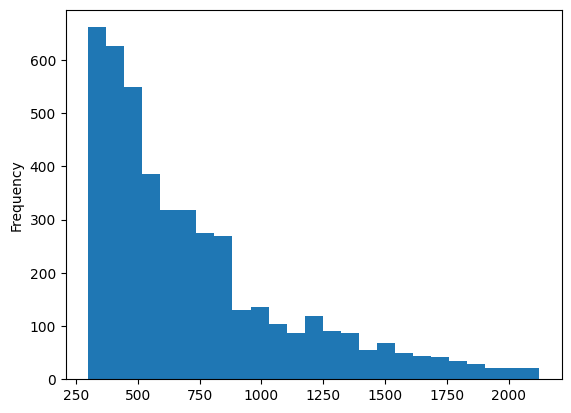

In [22]:
validas_julho['distance(m)'].plot(kind='hist', bins = 25);

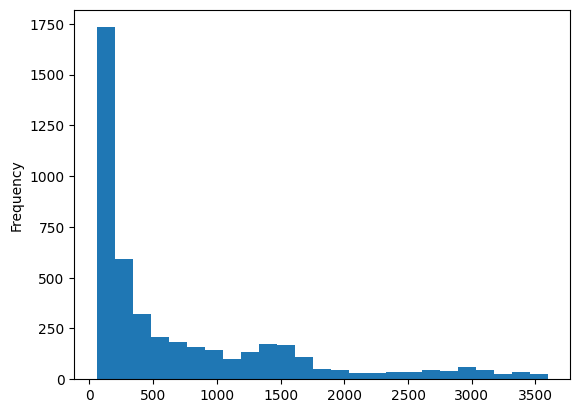

In [23]:
validas_julho['duration(s)'].plot(kind='hist', bins = 25);

In [24]:
# validas_julho.to_excel('viagens_validas_julho.xlsx', engine = 'openpyxl')

julho

julho.drop(axis = 1, labels= ['ID_VIAGEM'], inplace = True)

validas_julho['ID_VIAGEM'] = validas_julho['device_id'].astype('str') + '_' +  validas_julho['dataInicio'].dt.day.astype('str') + '_' + validas_julho['dataInicio'].dt.month.astype('str')
validas_julho['ID_VIAGEM'] 

validas_julho

validas_julho.day.value_counts().sort_index()#.plot(kind='hist', bins = 25);

- com o agrupado temos os pontos de onibus de chegada e saida
- 
- 